# Pre-compute stellar profiles

The other tutorials have demonstrated how ExoTiC-LD allows users to quickly compute limb-darkening coefficients for a given set of stellar parameters. This is all we need to do if we wish to fix these coefficients during an analysis of a transit.

However, if we wanted to assess how slight changes to the limb-darkening profile affect our inference of other parameters, we might want to vary the limb-darkening coefficients during the fit. We could simply let each coefficient float freely (e.g., using the "uninformative" priors between 0,1 for the Kipping 2013 law), or we could apply a complicated physically motivated prior.

Alternatively, however, we could fit not for the coefficients themselves, but for the physically-grounded parameters that control them: the stellar effective temperature, surface gravity, and metallicity. These values often already have well-constrained priors from other observations, and so we can use them to inform our limb-darkening profile in a more Bayesian sense.

We could use ExoTiC-LD's `StellarLimbDarkening` class to repeatedly compute limb-darkening coefficients as we explore different stellar parameters. But, this would require lots of file I/O, since this class must read in a stellar spectra file(s) each time it is called. This dominates the runtime of the code, and creates a bottleneck when running an MCMC chain or nested sampling algorithm.

We can avoid this by pre-computing stellar limb-darkening profiles for each spectra in our stellar grid, keeping all of those coefficients in memory, then interpolating between them on-the-fly. This tutorial demonstrates how to do that using the `PrecomputedLimbDarkening` class.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize

from exotic_ld import PrecomputedLimbDarkening
from exotic_ld import StellarLimbDarkening

from squishyplanet import OblateSystem

local_data_path = "ExoTic_LD_data"

To build a cache of $I(\mu)$ values, we need to specify a stellar grid and observing mode:

In [3]:
pld = PrecomputedLimbDarkening(
    ld_model="kurucz",
    ld_data_path=local_data_path,
    mode="JWST_NIRSpec_Prism",
    wavelength_range=None,
    custom_wavelengths=None,
    custom_throughput=None,
    interpolate_type="nearest",
    ld_data_version="3.2.0",
    verbose=2,
    save_stellar_grid=None,
)

setting the wavelength range...
Input stellar parameters are M_H=0.0, Teff=5500, logg=4.0.
Loading stellar model from kurucz grid.
Using interpolation type = nearest.
Exact match found with M_H=0.0, Teff=5500.0, logg=4.0.
Stellar model loaded.

No wavelength range provided, so using the max and min of the provided mode (JWST_NIRSpec_Prism): [6000.0, 53000.0] angstrom

kurucz models are saved by default
proceeding may download and save ~0.4 GB of data if it's not already present

retrieving KD tree

cache loaded from: ExoTic_LD_data/cached_mus/kurucz_JWST_NIRSpec_Prism_6000_53000.npy
Ready!


By default, the stellar spectra will be saved locally after the grid is built for the "kurucz" and "stagger" grids, but will be deleted as the cache is constructed for the "phoenix", "mps1", and "mps2" grids, since these are significantly larger. Once the cache is complete, it will be saved in the local directory alongside the other ExoTiC-LD data files and can be reused without needing to redownload or rebuild anything.

Now let's see why we might want to go through this initial effort. Let's first look at how long it might take to compute limb-darkening coeffcients for 100 potential M_h, Teff, and logg samples using the `StellarLimbDarkening` class:

In [14]:
%%timeit

np.random.seed(0)

m_hs = np.random.uniform(-5, 1, 100)
teffs = np.random.uniform(3500, 6500, 100)
loggs = np.random.uniform(3, 5, 100)


for m_h, teff, logg in zip(m_hs, teffs, loggs):
    
    sld = StellarLimbDarkening(
        M_H=m_h,
        Teff=teff,
        logg=logg,
        ld_model="kurucz",
        ld_data_path=local_data_path,
        interpolate_type="nearest",
        verbose=-1,
    )
    
    coeffs = sld.compute_4_parameter_non_linear_ld_coeffs(
        wavelength_range=[6_000.0, 53_000.0],
        mode="JWST_NIRSpec_Prism",
        custom_wavelengths=None,
        custom_throughput=None,
        return_sigmas=True,
    )

1.36 s ± 7.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now let's do the same for the `PrecomputedLimbDarkening` class:

In [15]:
%%timeit

np.random.seed(0)

pld = PrecomputedLimbDarkening(
    ld_model="kurucz",
    ld_data_path=local_data_path,
    mode="JWST_NIRSpec_Prism",
    wavelength_range=None,
    custom_wavelengths=None,
    custom_throughput=None,
    interpolate_type="nearest",
    ld_data_version="3.2.0",
    verbose=-1,
    save_stellar_grid=None,
)

m_hs = np.random.uniform(-5, 1, 100)
teffs = np.random.uniform(3500, 6500, 100)
loggs = np.random.uniform(3, 5, 100)


for m_h, teff, logg in zip(m_hs, teffs, loggs):
    
    coeffs = pld.compute_4_parameter_non_linear_ld_coeffs(
        M_H=m_h,
        Teff=teff,
        logg=logg,
        return_sigmas=True,
    )

76.8 ms ± 649 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


This is a significant speedup! And, when using `interpolate_type="nearest"`, the results from the two classes are identical. Note however that when using `interpolate_type="trilinear"`, the resulting coefficients will differ slightly, since the pre-computed version interpolates between $I(\mu)$ values, rather than the underlying stellar spectra.

Last, we can demonstrate the impact of varying the stellar parameters on a transit. Above we showed that `PrecomputedLimbDarkening` allows users to fit for all of the same limb-darkening laws as `StellarLimbDarkening`, though here we won't use any specific law. Instead, we'll use `PrecomputedLimbDarkening.get_I_mu()` to generate a stellar brightness profile for a given set of stellar parameters, then feed those to `squishyplanet` to compute the transit light curve. For more information on how to use `squishyplanet` and its handling of stellar brightness profiles, see the [squishyplanet documentation](https://squishyplanet.readthedocs.io/en/latest/index.html).

In [6]:
# create the pld object
pld = PrecomputedLimbDarkening(
    ld_model="kurucz",
    ld_data_path=local_data_path,
    mode="JWST_NIRSpec_Prism",
    wavelength_range=None,
    custom_wavelengths=None,
    custom_throughput=None,
    interpolate_type="trilinear",
    ld_data_version="3.2.0",
    verbose=-1,
    save_stellar_grid=None,
)
sorted_order = np.argsort(pld.mus)
sorted_mus = pld.mus[sorted_order]

In [7]:
# set up the light curve generation function

comapare_mh = 0.0
comapare_teff = 5500
comapare_logg = 4.4

# set up the squishyplanet system
base_params = {
    "t_peri" : -2.5, # units of days
    "times" : np.linspace(-0.25, 0.25, 500), # units of days
    "a" : 20.0, # units of stellar radii
    "period" : 10.0, # units of days
    "r" : 0.1, # units of stellar radii, roughly Jupiter's radius
    "i" : np.pi/2, # units of radians
    "ld_u_coeffs":np.zeros(10), # this is what we'll vary
    "tidally_locked" : False, 
}

def stellar_dependent_lightcurve(mh, teff, logg):
    # just changing the limb darkening will over-emphasize the effect, since we
    # can adjust the radius of the planet to compensate for much of the difference
    # so, here we optimize the planet radius to match the solar limb darkening case
    # as closely as possible

    # generate a lightcurve
    def _stellar_dependent_lightcurve(mh, teff, logg, r):
        # finer grid of mu values
        mu_grid = np.linspace(0, 1, 500)

        # core of the calculation
        i_mu = pld.get_I_mu(M_H=mh, Teff=teff, logg=logg)

        # interpolate between those values to avoid overfitting the polynomial
        spline_approx = CubicSpline(x=sorted_mus, y=i_mu[sorted_order])
        interpolated_vals = spline_approx(mu_grid)

        # fit the limb darkening profile
        u_coeffs = OblateSystem.fit_limb_darkening_profile(
                intensities=interpolated_vals, mus=mu_grid, order=10
        )
        system = OblateSystem(**base_params)

        lc = system.lightcurve({"ld_u_coeffs":u_coeffs, "r":r})
        return lc
    
    # create a penalty function to optimize
    base = _stellar_dependent_lightcurve(mh=comapare_mh, teff=comapare_teff, logg=comapare_logg, r=base_params["r"])
    def objective(r):
        lc = _stellar_dependent_lightcurve(mh=mh, teff=teff, logg=logg, r=r)
        return np.sum((lc - base)**2)
    
    result = minimize(objective, 0.1, tol=1e-9)
    r = result.x[0]
    return _stellar_dependent_lightcurve(mh=mh, teff=teff, logg=logg, r=r)

In [8]:
# create the 5500 K light curve we'll compare everything to
compare_curve = stellar_dependent_lightcurve(mh=comapare_mh, teff=comapare_teff, logg=comapare_logg)

# create a set of light curves for different temperatures
other_curves = []
for temp in np.arange(5_500, 6_001, 100):
    other_curves.append(stellar_dependent_lightcurve(mh=comapare_mh, teff=temp, logg=comapare_logg))


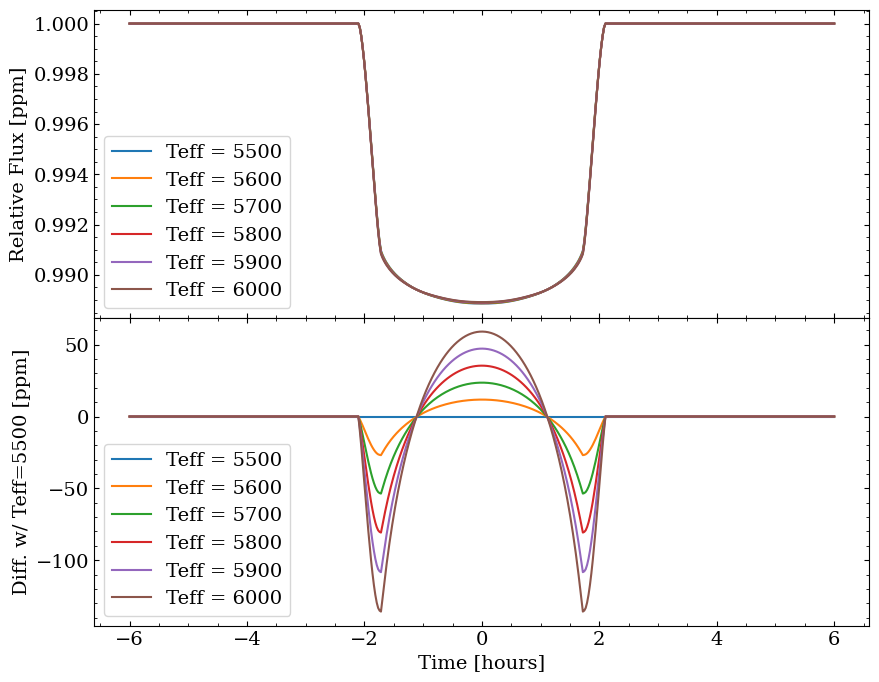

In [11]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 8), sharex=True)
for i, lc in enumerate(other_curves):
    ax[0].plot(base_params["times"]*24, lc, label=f"Teff = {5_500 + 100*i}")
    ax[1].plot(base_params["times"]*24, (lc-compare_curve)*1e6, label=f"Teff = {5_500 + 100*i}")
ax[0].set(ylabel="Relative Flux [ppm]")
ax[1].set(xlabel="Time [hours]", ylabel="Diff. w/ Teff=5500 [ppm]")
ax[0].legend();
ax[1].legend();
fig.subplots_adjust(hspace=0.0)

So, changing the temperature by ~100 K can produces effects on the order of 10s of ppm. That's not a huge effect, but is large enough to matter in some science cases, including [planetary oblateness](https://squishyplanet.readthedocs.io/en/latest/tutorials/fit_oblate_transit.html). Allowing users to fit for limb-darkening coefficients through physcially-motivated stellar parameters can help to ensure that these effects are properly accounted for in the analysis.